In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pickle

In [2]:
def calcshannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * math.log(prob, 2)
    return shannonEnt

def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

In [3]:
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcshannonEnt(dataSet)
    #print baseEntropy
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i , value)
            prob = len(subDataSet) / float(len(dataSet))
            newEntropy += prob * calcshannonEnt(subDataSet)
        #print newEntropy
        infoGain = baseEntropy - newEntropy
        if infoGain > bestInfoGain:
            bestInfoGain = infoGain
            bestFeature = i
    return bestFeature

def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClasscount = sorted(classCount.iteritems(), key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):   #如果所有的类标签相同
        return classList[0]
    if len(dataSet[0]) == 1:                              #如果用完了所有特征
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]                      #labels 是每一维特征的名字
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

In [4]:
def classify(inputTree, featLabels, testVec):
    firstStr = inputTree.keys()[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

def storeTree(inputTree, filename):
    fw = open(filename, 'w')
    pickle.dump(inputTree, fw)
    fw.close()
    
def grabTree(filename):
    fr = open(filename)
    return pickle.load(fr)

In [5]:
def loadDataSet():
    fr = open('lenses.txt')
    lenses = [inst.strip().split('\t') for inst in fr.readlines()]
    lenseLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
    return lenses, lenseLabels

In [12]:
dataSet, lenselabels = loadDataSet()

In [13]:
lenselabels

['age', 'prescript', 'astigmatic', 'tearRate']

In [14]:
mytree = createTree(dataSet, lenselabels)

In [15]:
getNumLeafs(mytree)

9

In [16]:
getTreeDepth(mytree)

4

(0.5, 1.0)
(0.5555555555555556, 0.75)
(0.33333333333333337, 0.5)
(0.2777777777777778, 0.25)
(0.7777777777777778, 0.5)
(0.7777777777777778, 0.25)


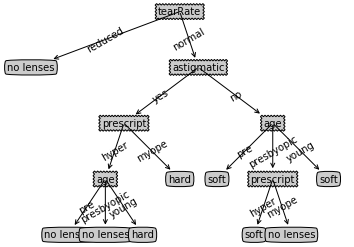

In [109]:
createPlot(mytree)

In [108]:
decisionNode = dict(boxstyle = 'sawtooth', fc = '0.8')
leafNode = dict(boxstyle='round4', fc = '0.8')
arrow_args = dict(arrowstyle = '<-')

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy = parentPt, xycoords = 'axes fraction', xytext = centerPt, textcoords = 'axes fraction', \
                           va = 'center', ha = 'center', bbox = nodeType, arrowprops = arrow_args)

def createPlot1():
    fig = plt.figure(1, facecolor = 'white')
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon = False)
    plotNode(u'决策节点', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode(u'叶节点', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()
    
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation = 30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]     #the text label for this node should be this
    cntrPt = ( plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
    print cntrPt
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
            #return 
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW
    plotTree.yOff = 1.0
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()
    

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [99]:
labels = ['no surfacing', 'flippers']
mytree = retrieveTree(0)
classify(mytree, labels, [1, 1])

'yes'

In [90]:
a = dict(a = 1, b = 2, c = 3)
fw = open('a.txt', 'w')
pickle.dump(a, fw)
fw.close()

In [91]:
fw = open('a.txt')
b = pickle.load(fw)
fw.close()

In [92]:
b

{'a': 1, 'b': 2, 'c': 3}

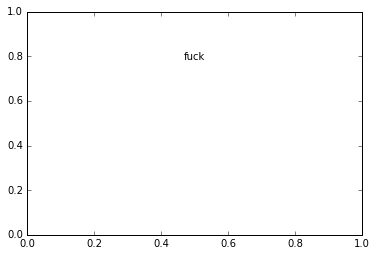

In [84]:
fig = plt.figure()
ax = plt.subplot(111)
ax.text(0.5, 0.8, 'fuck', va="center", ha="center")